# Grid-searching to optimize hyperparameters for tree-based models on TSNV_24 dataset

In [1]:
import numpy as np
import pandas as pd
import xgboost as xgb
import sys
import os
import matplotlib.pyplot as plt

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

%matplotlib inline

/userhome/cs/u3556490/anaconda3/envs/test/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
from sklearn.model_selection import train_test_split

def separateDataset(dataset, train_ratio):
    '''
    Takes in a dataset (pandas df) and a ratio value, returns a dictionary containing the separated dataset.
    Key "train" = train set, "dev" = dev set (size = train ratio * (sizeof input df - test set)), "test" = test set (size = train ratio * sizeof input df)
    '''
    train_dev_set, test_set = train_test_split(dataset, train_size=train_ratio, random_state=42)
    train_set, dev_set = train_test_split(train_dev_set, train_size=train_ratio, random_state=42)
    print("Training set size: {0}; Dev set size: {1}; Testing set size: {2}".format(len(train_set), len(dev_set), len(test_set)))
    return { "train": train_set, "dev": dev_set, "test": test_set }

def pandasToXY(dataframe):
    '''
    converts the given pandas df to X and Y sub-arrays. X is pandas df, Y is np int array.
    note: the range of columns to select as Y must be double checked when a different dataset is used.
    '''
    X = dataframe.drop(['LOW_IMPACT', 'MID_IMPACT', 'BIG_IMPACT', 'DIRECT_STRIKE'], axis=1)
    Y = np.asarray(dataframe.iloc[:,:4]).astype(int)
    return X, Y

dataset = pd.read_pickle('../Dataset/baseline_dataset_tsnv_24.gz')
# train-dev-test splitting
splitDataset = separateDataset(dataset, 0.9)
# separate each of the 3 sets into X and Y
train_full = splitDataset["train"]
train_X, train_Y = pandasToXY(train_full)
dev_full = splitDataset["dev"]
dev_X, dev_Y = pandasToXY(dev_full)
test_full = splitDataset["test"]
test_X, test_Y = pandasToXY(test_full)

Training set size: 36317; Dev set size: 4036; Testing set size: 4484


### Extra Trees
Considered because it shows remarkable performance in terms of Brier scores and capability at detecting direct strikes. As such, only one extra tree classifier will be optimized to hunt for direct strikes, so that it can augment the preexisting XGBoost classifier.

Best value for max_depth among \[10 .. 35\]: 35 (score strictly increases with depth)

Best value for n_estimators among \[200 .. 750\]: 700 

Best value for max_features among \[5,6,7,8,9,16,32,48,52,56,60,64\]: 48

Best value for min_samples_split among \[1,2,3,4,5\]: 2

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, f1_score
from sklearn.ensemble import ExtraTreesClassifier

param_grid = {"n_estimators": [350,400,450,500,550,600,650,700,750]}
estimator = ExtraTreesClassifier(max_features=48, max_depth=35, n_jobs=-1)

scorer = make_scorer(f1_score, zero_division=0)

# because extra trees fit extra fast, we can afford to have 4 folds cross-validation
gscv = GridSearchCV(estimator, param_grid, scoring=scorer, n_jobs=-1, verbose=2, cv=4).fit(train_X, train_Y[:,3]) # 3rd target

In [38]:
gscv.cv_results_

{'mean_fit_time': array([30.03057957, 33.15747422, 37.78805345, 42.1100117 , 46.39928061,
        50.51122922, 54.87360358, 59.04191297, 38.73519921]),
 'std_fit_time': array([0.63147772, 0.45530348, 0.23105964, 0.55284248, 0.36142964,
        0.49464852, 0.71787096, 0.55132502, 0.51495372]),
 'mean_score_time': array([0.99561048, 1.04714322, 1.16889209, 1.22897637, 1.39281464,
        1.42062545, 1.4696812 , 1.60006422, 0.92200232]),
 'std_score_time': array([0.08403018, 0.02720967, 0.07398854, 0.14278891, 0.05937921,
        0.03298531, 0.08524726, 0.24584919, 0.05586688]),
 'param_n_estimators': masked_array(data=[350, 400, 450, 500, 550, 600, 650, 700, 750],
              mask=[False, False, False, False, False, False, False, False,
                    False],
        fill_value='?',
             dtype=object),
 'params': [{'n_estimators': 350},
  {'n_estimators': 400},
  {'n_estimators': 450},
  {'n_estimators': 500},
  {'n_estimators': 550},
  {'n_estimators': 600},
  {'n_estimat

0.7950310559006211
0.2886394557823129


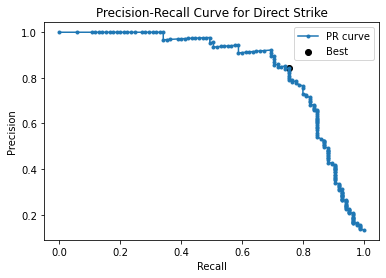

In [16]:
testing_model = ExtraTreesClassifier(n_estimators=700, max_depth=35, max_features=48, n_jobs=-1).fit(train_X, train_Y[:,3])

from sklearn.metrics import precision_recall_curve

preds = testing_model.predict_proba(dev_X)
precision, recall, thresholds = precision_recall_curve(dev_Y[:,3], preds[:,1])
fscore = (2 * precision * recall) / (precision + recall)
ix = np.nanargmax(fscore)
print(fscore[ix])
print(thresholds[ix])

plt.plot(recall, precision, marker='.', label='PR curve')
plt.scatter(recall[ix], precision[ix], marker='o', color='black', label='Best')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for Direct Strike')
plt.legend()

# the improvement is quite minimal, score was originally 0.81176 and now 0.80519. this may be bad RNG.

In [27]:
import joblib
from datetime import datetime

joblib.dump(testing_model, "./models/baseline_model_extraGSCV_{}.skl".format(str(datetime.now().strftime("%Y-%m-%d %H-%M"))))

['./models/baseline_model_extraGSCV_2022-03-09 19-57.skl']

### Extra Trees Regressor

In [64]:
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, f1_score, precision_recall_curve

param_grid = {"estimator__max_features": [28, 29, 30, 31]}

estimator = MultiOutputRegressor(ExtraTreesRegressor(
    n_jobs=-1, random_state=42, n_estimators=200, max_depth=25
), n_jobs=-1)

def my_scorer(y_true, y_pred):
    '''Returns the average f1 scores for the given label y_true and continuous y_pred.'''
    y_pred = np.clip(y_pred, 0, 1)
    best_thresholds = []
    for i in range(4):
        precision, recall, thresholds = precision_recall_curve(y_true[:,i], y_pred[:,i])
        fscore = (2 * precision * recall) / (precision + recall)
        ix = np.nanargmax(fscore)
        best_thresholds.append(thresholds[ix])
    preds = []
    for i in range(len(y_pred)):
        pred_row = []
        for j in range(4):
            if y_pred[i,j] > best_thresholds[j]:
                pred_row.append(1)
            else:
                pred_row.append(0)
        preds.append(pred_row)
    return f1_score(y_true, preds, zero_division=0, average='macro')

scorer = make_scorer(my_scorer)

gscv = GridSearchCV(estimator, param_grid, scoring=scorer, verbose=4, cv=3, n_jobs=-1, refit=False).fit(train_X, train_Y)

print(gscv.cv_results_)
print(gscv.best_params_)

Fitting 3 folds for each of 4 candidates, totalling 12 fits
{'mean_fit_time': array([44.87048038, 45.15869784, 38.2734677 , 23.94150352]), 'std_fit_time': array([0.16875583, 0.16820385, 9.98918523, 0.39927701]), 'mean_score_time': array([1.91057714, 1.77198124, 1.4557604 , 0.78795584]), 'std_score_time': array([0.06970658, 0.06327575, 0.39852978, 0.02416826]), 'param_estimator__max_features': masked_array(data=[28, 29, 30, 31],
             mask=[False, False, False, False],
       fill_value='?',
            dtype=object), 'params': [{'estimator__max_features': 28}, {'estimator__max_features': 29}, {'estimator__max_features': 30}, {'estimator__max_features': 31}], 'split0_test_score': array([0.7888462 , 0.78747481, 0.77971748, 0.78702678]), 'split1_test_score': array([0.78107764, 0.77937784, 0.7850326 , 0.78405795]), 'split2_test_score': array([0.79470801, 0.78418061, 0.78534934, 0.78539187]), 'mean_test_score': array([0.78821062, 0.78367776, 0.78336647, 0.7854922 ]), 'std_test_score'

In [65]:
testing_model = MultiOutputRegressor(ExtraTreesRegressor(
    n_jobs=-1, random_state=42, n_estimators=200, max_depth=25, max_features=28
), n_jobs=-1).fit(train_X, train_Y)

Best Threshold=0.31000, F-Score=0.86162
Best Threshold=0.42000, F-Score=0.84249
Best Threshold=0.26286, F-Score=0.79149
Best Threshold=0.26500, F-Score=0.80503
              precision    recall  f1-score   support

           0    0.82872   0.89402   0.86013       368
           1    0.88417   0.80070   0.84037       286
           2    0.76033   0.81416   0.78632       113
           3    0.86301   0.74118   0.79747        85

   micro avg    0.83882   0.83685   0.83784       852
   macro avg    0.83406   0.81251   0.82107       852
weighted avg    0.84168   0.83685   0.83746       852
 samples avg    0.10076   0.09936   0.09770       852

Class 0, no calibration: 0.021057
Class 1, no calibration: 0.018152
Class 2, no calibration: 0.010320
Class 3, no calibration: 0.008892


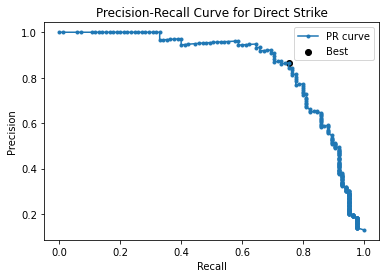

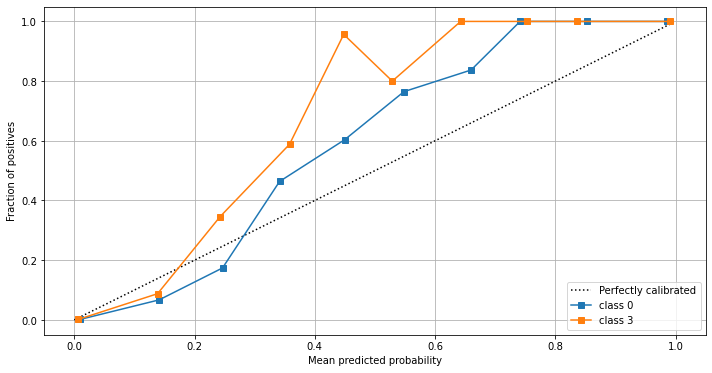

In [66]:
from sklearn.metrics import precision_recall_curve, brier_score_loss, classification_report
from sklearn.calibration import CalibrationDisplay
from matplotlib.gridspec import GridSpec

# to edit
preds = np.clip(testing_model.predict(dev_X), 0, 1)
best_thresholds = []
best_f1_scores = []
n_classes = 4
preds = np.array(preds)
for i in range(n_classes):
    precision, recall, thresholds = precision_recall_curve(dev_Y[:,i], preds[:,i])
    # find best threshold
    fscore = (2 * precision * recall) / (precision + recall)
    ix = np.argmax(fscore)
    best_thresholds.append(thresholds[ix])
    best_f1_scores.append(fscore[ix])
    print('Best Threshold={0:.05f}, F-Score={1:.05f}'.format(thresholds[ix], fscore[ix]))

# plot the precision-recall curve for the last class/label
plt.plot(recall, precision, marker='.', label='PR curve')
plt.scatter(recall[ix], precision[ix], marker='o', color='black', label='Best')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for Direct Strike')
plt.legend()

preds_probs = np.clip(testing_model.predict(dev_X), 0, 1)
n_classes = 4
preds = []
for i in range(len(preds_probs)):
    pred_row = []
    for j in range(n_classes):
        if preds_probs[i,j] > best_thresholds[j]:
            pred_row.append(1)
        else:
            pred_row.append(0)
    preds.append(pred_row)
        
preds = np.array(preds)

print(classification_report(dev_Y, preds, zero_division=0, digits=5))

all_preds = np.clip(testing_model.predict(dev_X), 0, 1)
for i in range(4):         
    preds = all_preds[:,i]
    clf_score = brier_score_loss(dev_Y[:,i], preds)
    print("Class {0}, no calibration: {1:1.6f}".format(i, clf_score))

# plot calibration graphs
fig = plt.figure(figsize=(10, 10))
gs = GridSpec(4, 2)
ax = fig.add_subplot(gs[:2, :2])

all_preds = np.clip(testing_model.predict(dev_X), 0, 1)
preds = all_preds[:,0]
display = CalibrationDisplay.from_predictions(dev_Y[:,0], preds, n_bins=10, name="class 0", ax=ax, strategy='uniform')
preds = all_preds[:,3]
display = CalibrationDisplay.from_predictions(dev_Y[:,3], preds, n_bins=10, name="class 3", ax=ax, strategy='uniform')

ax.grid()
plt.tight_layout()
plt.show()

In [67]:
import joblib
from datetime import datetime

joblib.dump(testing_model, "./models/baseline_model_gscv_extra_trees_regr_{}.skl".format(str(datetime.now().strftime("%Y-%m-%d %H-%M"))))

['./models/baseline_model_gscv_extra_trees_regr_2022-04-15 21-47.skl']

### XGBoost classifier

max_depth: from \[5, 10, 15, 20, 25, 26, 27\], best value 27 (28 and plus regularly OOMs on the GPU)  
subsample: from \[0.25, 0.5, 0.75, 0.875, 1.0\], best value 1.0  
colsample_bytree: from \[0.25, 0.5, 0.75, 0.875, 1.0\], best value 1.0  
min_child_weight: from \[0.25,0.5,0.75,1,3,5,7,9\], best value 0.5  
learning_rate: from \[0.25, 0.2, 0.15, 0.1, 0.09, 0.075, 0.05, 0.01, 0.005, 0.001\], best value 0.175   
reg_alpha: from \[1.0, 0.1, 0.01, 0.005, 0.001, 0.0005, 0.0001\], best value 0.005  
reg_lambda: from \[4.0, 3.0, 2.0, 1.75, 1.5, 1.0, 0.5, 0.1, 0.01, 0.001, 0.0001\], best value 2.0  
gamma: from \[1.0, 0.1, 0.01, 0.005, 0.001, 0.0005, 0.0001\], best value 0.001  
n_estimators: from \[100, 200, 300, 400, 500, 600, 700, 800\], best value 600-650 (>700 risks OOM on the GPU)   

In [6]:
from sklearn.multioutput import MultiOutputClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, f1_score

param_grid = {"estimator__max_depth": [25, 26, 27]}

estimator = MultiOutputClassifier(xgb.XGBClassifier(
    n_estimators=600, min_child_weight=0.5, colsample_bytree=1.0, subsample=1.0, learning_rate=0.175, reg_alpha=0.005, reg_lambda=2.0, gamma=0.001,
    tree_method='gpu_hist', n_jobs=-1, random_state=42, use_label_encoder=False, eval_metric='logloss'
), n_jobs=-1)

scorer = make_scorer(f1_score, zero_division=0, average='macro')

gscv = GridSearchCV(estimator, param_grid, scoring=scorer, verbose=2, cv=3, n_jobs=1).fit(train_X, train_Y)

Fitting 3 folds for each of 3 candidates, totalling 9 fits


/userhome/cs/u3556490/anaconda3/envs/test/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/userhome/cs/u3556490/anaconda3/envs/test/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/userhome/cs/u3556490/anaconda3/envs/test/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/userhome/cs/u3556490/anaconda3/envs/test/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is depre

[CV] END ............................estimator__max_depth=25; total time= 3.7min
[CV] END ............................estimator__max_depth=25; total time= 3.7min
[CV] END ............................estimator__max_depth=25; total time= 3.7min
[CV] END ............................estimator__max_depth=26; total time= 7.5min


/userhome/cs/u3556490/anaconda3/envs/test/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/userhome/cs/u3556490/anaconda3/envs/test/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/userhome/cs/u3556490/anaconda3/envs/test/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/userhome/cs/u3556490/anaconda3/envs/test/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is depre

[CV] END ............................estimator__max_depth=26; total time= 7.6min


/userhome/cs/u3556490/anaconda3/envs/test/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/userhome/cs/u3556490/anaconda3/envs/test/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/userhome/cs/u3556490/anaconda3/envs/test/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/userhome/cs/u3556490/anaconda3/envs/test/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is depre

[CV] END ............................estimator__max_depth=26; total time= 7.6min


/userhome/cs/u3556490/anaconda3/envs/test/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/userhome/cs/u3556490/anaconda3/envs/test/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/userhome/cs/u3556490/anaconda3/envs/test/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/userhome/cs/u3556490/anaconda3/envs/test/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is depre

[CV] END ............................estimator__max_depth=27; total time=15.0min


/userhome/cs/u3556490/anaconda3/envs/test/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/userhome/cs/u3556490/anaconda3/envs/test/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/userhome/cs/u3556490/anaconda3/envs/test/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/userhome/cs/u3556490/anaconda3/envs/test/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is depre

[CV] END ............................estimator__max_depth=27; total time=15.0min


/userhome/cs/u3556490/anaconda3/envs/test/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/userhome/cs/u3556490/anaconda3/envs/test/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/userhome/cs/u3556490/anaconda3/envs/test/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/userhome/cs/u3556490/anaconda3/envs/test/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is depre

[CV] END ............................estimator__max_depth=27; total time=14.9min


In [7]:
gscv.cv_results_

{'mean_fit_time': array([218.67821129, 451.06834499, 895.59241366]),
 'std_fit_time': array([0.79565372, 4.08547814, 1.21853472]),
 'mean_score_time': array([1.88505785, 1.60663859, 1.53183277]),
 'std_score_time': array([0.65025245, 0.14382726, 0.05687656]),
 'param_estimator__max_depth': masked_array(data=[25, 26, 27],
              mask=[False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'estimator__max_depth': 25},
  {'estimator__max_depth': 26},
  {'estimator__max_depth': 27}],
 'split0_test_score': array([0.73474007, 0.73207726, 0.73307113]),
 'split1_test_score': array([0.70757812, 0.70728701, 0.71057713]),
 'split2_test_score': array([0.76076874, 0.75834277, 0.76422839]),
 'mean_test_score': array([0.73436231, 0.73256901, 0.73595889]),
 'std_test_score': array([0.02171662, 0.02084633, 0.02199801]),
 'rank_test_score': array([2, 3, 1], dtype=int32)}

Best Threshold=0.19491, F-Score=0.87123
Best Threshold=0.18867, F-Score=0.86261
Best Threshold=0.07011, F-Score=0.82759
Best Threshold=0.10758, F-Score=0.81013


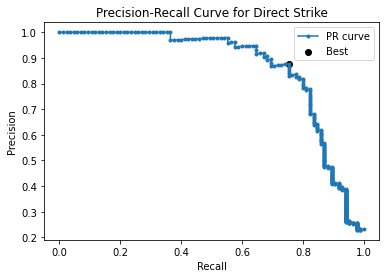

In [10]:
testing_model = MultiOutputClassifier(xgb.XGBClassifier(
    max_depth=27, n_estimators=600, 
    min_child_weight=0.5, colsample_bytree=1.0, subsample=1.0, learning_rate=0.175,
    reg_alpha=0.005, reg_lambda=2.0, gamma=0.001,
    tree_method='gpu_hist', n_jobs=-1, random_state=42, use_label_encoder=False, eval_metric='logloss'
), n_jobs=-1).fit(train_X, train_Y)

from sklearn.metrics import precision_recall_curve

# to edit
preds = testing_model.predict_proba(dev_X)
best_thresholds = []
best_f1_scores = []
n_classes = len(testing_model.classes_)
preds = np.array(preds)
for i in range(n_classes):
    precision, recall, thresholds = precision_recall_curve(dev_Y[:,i], preds[i,:,1])
    # find best threshold
    fscore = (2 * precision * recall) / (precision + recall)
    ix = np.argmax(fscore)
    best_thresholds.append(thresholds[ix])
    best_f1_scores.append(fscore[ix])
    print('Best Threshold={0:.05f}, F-Score={1:.05f}'.format(thresholds[ix], fscore[ix]))

# plot the precision-recall curve for the last class/label
plt.plot(recall, precision, marker='.', label='PR curve')
plt.scatter(recall[ix], precision[ix], marker='o', color='black', label='Best')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for Direct Strike')
plt.legend()

In [11]:
from sklearn.metrics import classification_report

preds_probs = np.array(testing_model.predict_proba(dev_X))
n_classes = len(testing_model.classes_)
preds = []
for i in range(preds_probs.shape[1]):
    pred_row = []
    for j in range(n_classes):
        if preds_probs[j,i,1] > best_thresholds[j]:
            pred_row.append(1)
        else:
            pred_row.append(0)
    preds.append(pred_row)
        
preds = np.array(preds)

print(classification_report(dev_Y, preds, zero_division=0, digits=5))
# n.b.: the improvement is quite minimal: average grew from 0.81397 to 0.83884.

              precision    recall  f1-score   support

           0    0.87812   0.86141   0.86968       368
           1    0.85764   0.86364   0.86063       286
           2    0.80508   0.84071   0.82251       113
           3    0.87500   0.74118   0.80255        85

   micro avg    0.86055   0.84742   0.85393       852
   macro avg    0.85396   0.82673   0.83884       852
weighted avg    0.86125   0.84742   0.85369       852
 samples avg    0.09940   0.09890   0.09731       852



In [12]:
import joblib
from datetime import datetime

joblib.dump(testing_model, "./models/baseline_model_xgbGSCV_{}.skl".format(str(datetime.now().strftime("%Y-%m-%d %H-%M"))))

['./models/baseline_model_xgbGSCV_2022-03-11 15-54.skl']

### XGBoost Regressor

In [47]:
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, f1_score, precision_recall_curve

param_grid = {"estimator__max_depth": [5, 10, 15, 20, 25]}

estimator = MultiOutputRegressor(xgb.XGBRegressor(
    n_estimators=350, min_child_weight=0.5, colsample_bytree=0.625, subsample=1.0, learning_rate=0.075, reg_alpha=1.25, 
    reg_lambda=0.1, gamma=1e-4, tree_method='gpu_hist', n_jobs=-1, random_state=42, use_label_encoder=False, eval_metric='logloss'
), n_jobs=-1)

def my_scorer(y_true, y_pred):
    '''Returns the average f1 scores for the given label y_true and continuous y_pred.'''
    y_pred = np.clip(y_pred, 0, 1)
    best_thresholds = []
    for i in range(4):
        precision, recall, thresholds = precision_recall_curve(y_true[:,i], y_pred[:,i])
        fscore = (2 * precision * recall) / (precision + recall)
        ix = np.nanargmax(fscore)
        best_thresholds.append(thresholds[ix])
    preds = []
    for i in range(len(y_pred)):
        pred_row = []
        for j in range(4):
            if y_pred[i,j] > best_thresholds[j]:
                pred_row.append(1)
            else:
                pred_row.append(0)
        preds.append(pred_row)
    return f1_score(y_true, preds, zero_division=0, average='macro')

scorer = make_scorer(my_scorer)

gscv = GridSearchCV(estimator, param_grid, scoring=scorer, verbose=4, cv=3, n_jobs=-1, refit=False).fit(train_X, train_Y)

Fitting 3 folds for each of 5 candidates, totalling 15 fits


/userhome/cs/u3556490/anaconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/userhome/cs/u3556490/anaconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/userhome/cs/u3556490/anaconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/userhome/cs/u3556490/anaconda3/envs/test/lib/python3.9/site-packages/xgb

[CV 3/3] END ......estimator__learning_rate=0.1;, score=0.739 total time= 3.0min
[CV 1/3] END ....estimator__learning_rate=0.025;, score=0.722 total time= 2.2min
[CV 1/3] END ..........estimator__reg_alpha=0.1;, score=0.744 total time= 2.6min
[CV 2/3] END ..........estimator__reg_alpha=5.0;, score=0.722 total time= 1.4min
[CV 1/3] END .........estimator__reg_alpha=1.25;, score=0.770 total time= 1.9min
[CV 1/3] END .........estimator__reg_lambda=2.5;, score=0.773 total time= 2.1min
[CV 3/3] END .........estimator__reg_lambda=0.1;, score=0.780 total time= 1.8min
[CV 1/3] END .........estimator__reg_lambda=0.1;, score=0.776 total time= 2.1min
[CV 2/3] END ..............estimator__gamma=1.0;, score=0.624 total time=  16.4s
[CV 1/3] END .............estimator__gamma=0.05;, score=0.696 total time=  33.3s
[CV 3/3] END ............estimator__gamma=0.005;, score=0.748 total time=  41.2s
[CV 2/3] END ............estimator__gamma=0.001;, score=0.738 total time= 1.6min
[CV 3/3] END ...........esti

In [48]:
gscv.cv_results_

{'mean_fit_time': array([ 64.52341525, 163.3808829 , 204.44613425, 187.96923979,
        397.15931884]),
 'std_fit_time': array([ 0.7941681 ,  3.99478658, 11.60361347, 33.96499775, 16.56454736]),
 'mean_score_time': array([0.91679128, 1.14698919, 1.40613445, 1.14632098, 0.91665649]),
 'std_score_time': array([0.10107609, 0.13726956, 0.23203683, 0.04856062, 0.15794959]),
 'param_estimator__max_depth': masked_array(data=[5, 10, 15, 20, 25],
              mask=[False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'estimator__max_depth': 5},
  {'estimator__max_depth': 10},
  {'estimator__max_depth': 15},
  {'estimator__max_depth': 20},
  {'estimator__max_depth': 25}],
 'split0_test_score': array([0.70181689, 0.78172097, 0.78034819, 0.77712328, 0.7722734 ]),
 'split1_test_score': array([0.68084761, 0.75796367, 0.76345015, 0.76007496, 0.76514486]),
 'split2_test_score': array([0.71488584, 0.78950045, 0.78749621, 0.78639848, 0.78193289]),
 'mean

In [49]:
gscv.best_params_

{'estimator__max_depth': 15}

[CV 3/3] END ....estimator__learning_rate=0.125;, score=0.743 total time= 3.0min
[CV 3/3] END ....estimator__learning_rate=0.025;, score=0.729 total time= 2.2min
[CV 3/3] END ..........estimator__reg_alpha=0.1;, score=0.752 total time= 2.6min
[CV 1/3] END ..........estimator__reg_alpha=5.0;, score=0.743 total time= 1.4min
[CV 2/3] END .........estimator__reg_alpha=1.25;, score=0.744 total time= 1.8min
[CV 3/3] END .........estimator__reg_lambda=5.0;, score=0.781 total time= 2.1min
[CV 1/3] END ........estimator__reg_lambda=0.25;, score=0.773 total time= 2.1min
[CV 2/3] END ........estimator__reg_lambda=0.01;, score=0.748 total time= 1.1min
[CV 3/3] END ..............estimator__gamma=0.1;, score=0.695 total time=  22.1s
[CV 2/3] END .............estimator__gamma=0.01;, score=0.710 total time=  47.8s
[CV 3/3] END ............estimator__gamma=0.001;, score=0.767 total time=  37.9s
[CV 2/3] END ...........estimator__gamma=0.0005;, score=0.740 total time= 1.7min
[CV 1/3] END ...........esti

In [50]:
testing_model = MultiOutputRegressor(xgb.XGBRegressor(
    max_depth=15, n_estimators=350, min_child_weight=0.5, colsample_bytree=0.625, subsample=1.0, learning_rate=0.075, reg_alpha=1.25, 
    reg_lambda=0.1, gamma=1e-4, tree_method='gpu_hist', n_jobs=-1, random_state=42, use_label_encoder=False, eval_metric='logloss'
), n_jobs=-1).fit(train_X, train_Y)

/userhome/cs/u3556490/anaconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/userhome/cs/u3556490/anaconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/userhome/cs/u3556490/anaconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/userhome/cs/u3556490/anaconda3/envs/test/lib/python3.9/site-packages/xgb

Best Threshold=0.37859, F-Score=0.85359
Best Threshold=0.40761, F-Score=0.85968
Best Threshold=0.26239, F-Score=0.77447
Best Threshold=0.32093, F-Score=0.83019
              precision    recall  f1-score   support

           0    0.86761   0.83696   0.85201       368
           1    0.87319   0.84266   0.85765       286
           2    0.74380   0.79646   0.76923       113
           3    0.89041   0.76471   0.82278        85

   micro avg    0.85333   0.82629   0.83959       852
   macro avg    0.84375   0.81019   0.82542       852
weighted avg    0.85533   0.82629   0.84001       852
 samples avg    0.09706   0.09688   0.09472       852

Class 0, no calibration: 0.021599
Class 1, no calibration: 0.017350
Class 2, no calibration: 0.010197
Class 3, no calibration: 0.007881


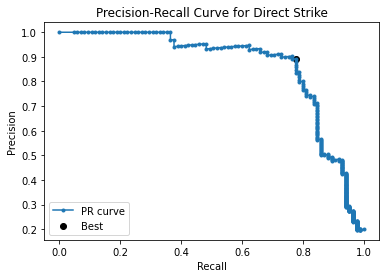

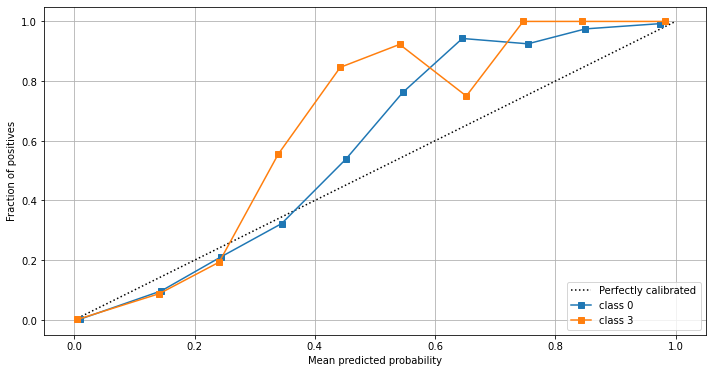

In [58]:
from sklearn.metrics import precision_recall_curve, brier_score_loss, classification_report
from sklearn.calibration import CalibrationDisplay
from matplotlib.gridspec import GridSpec

# to edit
preds = np.clip(testing_model.predict(dev_X), 0, 1)
best_thresholds = []
best_f1_scores = []
n_classes = 4
preds = np.array(preds)
for i in range(n_classes):
    precision, recall, thresholds = precision_recall_curve(dev_Y[:,i], preds[:,i])
    # find best threshold
    fscore = (2 * precision * recall) / (precision + recall)
    ix = np.argmax(fscore)
    best_thresholds.append(thresholds[ix])
    best_f1_scores.append(fscore[ix])
    print('Best Threshold={0:.05f}, F-Score={1:.05f}'.format(thresholds[ix], fscore[ix]))

# plot the precision-recall curve for the last class/label
plt.plot(recall, precision, marker='.', label='PR curve')
plt.scatter(recall[ix], precision[ix], marker='o', color='black', label='Best')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for Direct Strike')
plt.legend()

preds_probs = np.clip(testing_model.predict(dev_X), 0, 1)
n_classes = 4
preds = []
for i in range(len(preds_probs)):
    pred_row = []
    for j in range(n_classes):
        if preds_probs[i,j] > best_thresholds[j]:
            pred_row.append(1)
        else:
            pred_row.append(0)
    preds.append(pred_row)
        
preds = np.array(preds)

print(classification_report(dev_Y, preds, zero_division=0, digits=5))

all_preds = np.clip(testing_model.predict(dev_X), 0, 1)
for i in range(4):         
    preds = all_preds[:,i]
    clf_score = brier_score_loss(dev_Y[:,i], preds)
    print("Class {0}, no calibration: {1:1.6f}".format(i, clf_score))

# plot calibration graphs
fig = plt.figure(figsize=(10, 10))
gs = GridSpec(4, 2)
ax = fig.add_subplot(gs[:2, :2])

all_preds = np.clip(testing_model.predict(dev_X), 0, 1)
preds = all_preds[:,0]
display = CalibrationDisplay.from_predictions(dev_Y[:,0], preds, n_bins=10, name="class 0", ax=ax, strategy='uniform')
preds = all_preds[:,3]
display = CalibrationDisplay.from_predictions(dev_Y[:,3], preds, n_bins=10, name="class 3", ax=ax, strategy='uniform')

ax.grid()
plt.tight_layout()
plt.show()

In [59]:
import joblib
from datetime import datetime

joblib.dump(testing_model, "./models/baseline_model_gscv_xgb_regr_{}.skl".format(str(datetime.now().strftime("%Y-%m-%d %H-%M"))))

['./models/baseline_model_gscv_xgb_regr_2022-04-15 21-31.skl']